In [1]:
from explainers.GNNBoundary.gnn_boundary.models.linear_gcn_classifier import LinearGCNClassifier as LinearGCNClassifier
import torch as torch

In [2]:
import numpy as np

In [5]:

model = LinearGCNClassifier( num_classes=2, node_features=3, hidden_channels=16)
model.load_state_dict(torch.load('model/report_models/red_ratio.pt'))

<All keys matched successfully>

In [6]:
from graph_generation.RedRatioGraphs import RedRatioGraphs
import libraries.dataLoaderWrapper as DLW
dataset = DLW.GNNInterpreterLoaderWrapper(RedRatioGraphs(2000).getDataset())
mean_embeds = dataset.mean_embeddings(model)


In [7]:
y = [data.y for data in dataset]
classes = np.unique(y)
class_indexes = []
for c in classes:
    class_indexes.append(np.where(y == c)[0])
class_indexes

[array([   0,    1,    2, ..., 1997, 1998, 1999]),
 array([   5,    7,   10,   17,   18,   20,   25,   31,   34,   40,   46,
          50,   51,   60,   65,   68,   69,   77,   78,   80,   83,   85,
          86,   88,   89,   99,  104,  106,  109,  110,  126,  129,  131,
         145,  147,  149,  159,  167,  169,  177,  182,  183,  185,  187,
         190,  198,  199,  203,  206,  208,  210,  213,  216,  220,  221,
         225,  232,  233,  234,  242,  246,  254,  273,  274,  275,  277,
         281,  283,  286,  287,  290,  292,  295,  297,  299,  301,  302,
         312,  314,  321,  327,  328,  331,  332,  339,  352,  353,  355,
         358,  360,  365,  368,  372,  375,  376,  382,  383,  385,  392,
         394,  397,  398,  399,  401,  407,  410,  411,  412,  415,  416,
         418,  419,  423,  425,  435,  438,  448,  450,  462,  463,  466,
         467,  471,  479,  481,  490,  500,  502,  504,  509,  512,  515,
         516,  518,  524,  525,  534,  537,  538,  541,  544,

In [8]:

trainers = {}

In [10]:
from explainers.gnninterpreter import *
c = 1

trainers[c] = Trainer(
            sampler=(s := GraphSampler(
                max_nodes=5,
                num_node_cls=3,
                temperature=0.15,
                learn_node_feat=True
            )),
            discriminator=model,
            criterion=WeightedCriterion([
                dict(key="logits", criterion=ClassScoreCriterion(class_idx=c, mode='maximize'), weight=5),
                #dict(key="logits", criterion=ClassScoreCriterion(class_idx=, mode='minimize'), weight=5),
                dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[c]), weight=5),
                dict(key="logits", criterion=MeanPenalty(), weight=0),
                dict(key="omega", criterion=NormPenalty(order=1), weight=1),
                dict(key="omega", criterion=NormPenalty(order=2), weight=1),
                dict(key="xi", criterion=NormPenalty(order=1), weight=0),
                dict(key="xi", criterion=NormPenalty(order=2), weight=0),
                # dict(key="eta", criterion=NormPenalty(order=1), weight=0),
                # dict(key="eta", criterion=NormPenalty(order=2), weight=0),
                dict(key="theta_pairs", criterion=KLDivergencePenalty(binary=True), weight=1),
            ]),
            optimizer=(o := torch.optim.SGD(s.parameters(), lr=1)),
            scheduler=torch.optim.lr_scheduler.ExponentialLR(o, gamma=1),
            dataset=dataset,
            budget_penalty=BudgetPenalty(budget=10, order=2, beta=1),
            target_probs={c: (0.9, 1)},
            k_samples=16
        )
trainers[c].train(2000)

  0%|          | 0/2000 [00:00<?, ?it/s]

True

n=2 m=1
logits=[-29.7197208404541, 28.5679931640625]
probs=[4.8525305633449074e-26, 1.0]


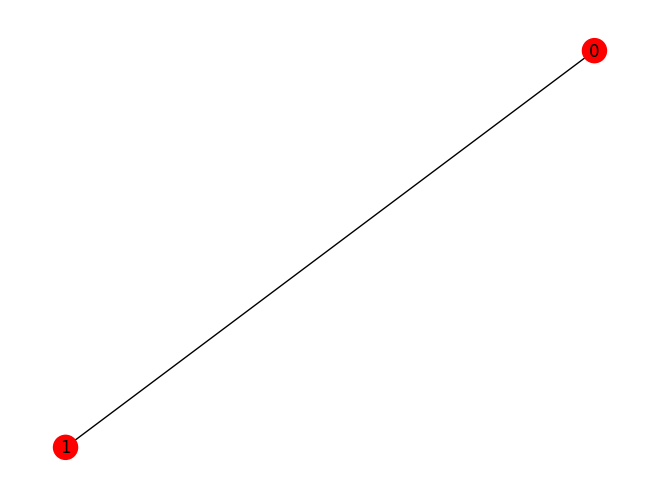

(<networkx.classes.graph.Graph at 0x7f328ad524a0>,
 {'n': 2,
  'm': 1,
  'logits': [-29.7197208404541, 28.5679931640625],
  'probs': [4.8525305633449074e-26, 1.0]})

In [11]:
trainers[1].evaluate(threshold=0.5, show=True)

n=5 m=5
logits=[6.7573370933532715, -5.082614898681641]
probs=[0.999992847442627, 7.210591320472304e-06]


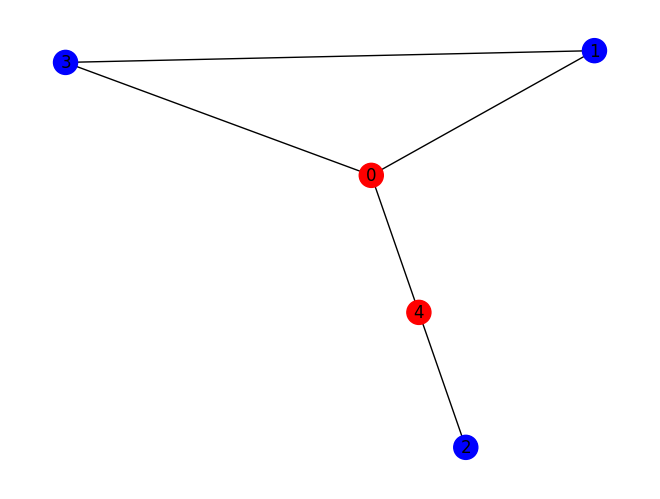

(<networkx.classes.graph.Graph at 0x7f327dea19f0>,
 {'n': 5,
  'm': 5,
  'logits': [6.7573370933532715, -5.082614898681641],
  'probs': [0.999992847442627, 7.210591320472304e-06]})

In [12]:
trainers[0].evaluate(threshold=0.5, show=True)